# Complete image processing
This is the notebook in which I would load a stack of real images and then test an entire processing pipeline

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rc('image', cmap='inferno')

In [2]:
import sys
sys.path.append("/home/dshteinbok/denoising_experiments/")
import isxd_reader
import denoising

In [3]:
import scipy.signal

In [4]:
movie_path = "/home/dshteinbok/denoising_experiments/2022-10-14-07-48-47_video.isxd"
full_stack = isxd_reader.img_stack(movie_path)

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1" 

The commented out code above was me loading from the original `isxd` recording. The problem with this was that image features moved around non-rigidly, so my methods involving temporal means caused blurring. To get rid of this I applied NoRMCorre ([Pnevmatikakis, 2017](https://doi.org/10.1016/j.jneumeth.2017.07.031)) to produce a new `tif` movie. This new motion-corrected movie should be loaded instead of the raw `isxd` as above.

In [6]:
# import imageio
# full_stack = imageio.volread("/home/dshteinbok/denoising_experiments/2022-10-14-07-48-47_video_normcorre.tif")

In [7]:
full_stack.shape

(80, 400, 640)

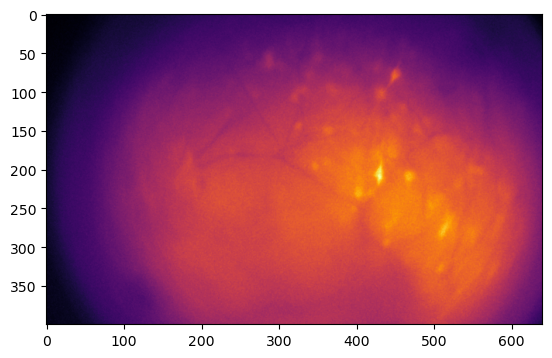

In [8]:
plt.imshow(full_stack[30])

In [9]:
full_stack[30].shape

(400, 640)

### Making the Multiwienernet
To initialize the multiwienernet, we need starting PSFs and Ks. These are immediately replaced with the learned PSFs and Ks loaded from disk, but I wonder whether the size of the PSFs with which this is initialized is important in terms of the PSF dimensions. If it is, that means that everywhere we load it, we must input the path to those PSFs. Alternatively, we could just write a function that loads the same large PSFs behind the scenes that just have to be present on the user's machine.

Just verified that the initial size of the PSFs _is_ important.

Perhaps rather than actually loading some number of PSFs, I will just create an appropriately-sized empty `ndarray` that is immediately replaced by whatever is loaded from disk

The size of `psfs` that is fed into the initialized multiwienernet is `(800, 1280, 21)` regardless of the size of the PSF (64x64 or 32x32) taken from Zemax.

In [10]:
import preset_nn

model = preset_nn.instant_multiwienernet()

model.load_weights("saved_models/multiwiener_nV3_probe_noisy2/model_weights")
# model.load_weights("saved_models/multiwiener_nV3_probe/model_weights")

2023-01-12 14:21:52.869551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 14:21:52.981670: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-12 14:21:53.748615: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dshteinbok/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../../../lib::/home/dshteinbok/miniconda3/lib/:/home/dshteinbok/miniconda3/envs/tf/lib/
2023-01-12 14:21:53.748679: W tensorflow/stream_execu

In [11]:
import cv2
cv2.resize?

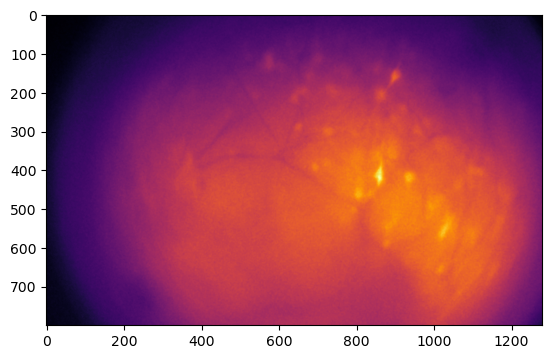

In [12]:
plt.imshow(cv2.resize(full_stack[30], (1280, 800)))

2023-01-12 14:21:57.795635: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-01-12 14:21:58.573444: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


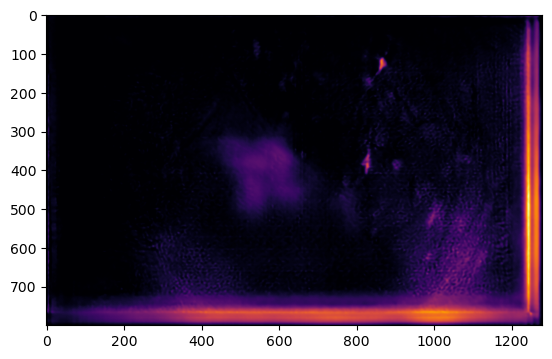

In [13]:
upsampled_img = np.empty((800,1280))
cv2.resize(full_stack[30], (1280, 800), upsampled_img)
plt.imshow((model(upsampled_img.reshape((1,800,1280,1)))[0,:,:]))

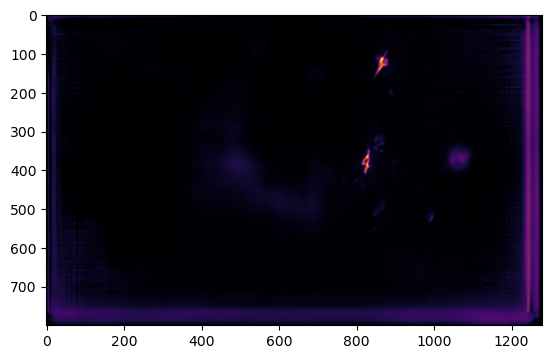

In [14]:
denoised_img = denoising.full_denoising(full_stack, 30, np.mean(full_stack, axis=0), h=8)

plt.imshow((model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))

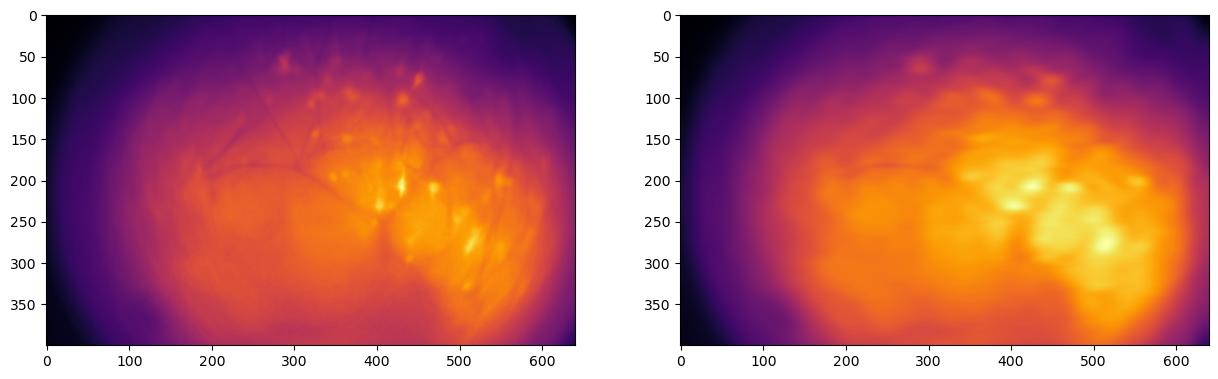

In [15]:
import scipy.fftpack
background = np.mean(full_stack, axis=0)
fig, axs = plt.subplots(1,2,figsize=(15,15))
axs[0].imshow(background)
background_dct = scipy.fftpack.dct(background)
background_dct[5:, 32:] = 0
background_lowpass = scipy.fftpack.idct(background_dct)
background_lowpass -= np.min(background_lowpass)
background_lowpass *= (np.max(background) - np.min(background))/np.max(background_lowpass)
background_lowpass += np.min(background)
axs[1].imshow(background_lowpass)

In [16]:
np.max(background_lowpass)

1478.775

In [17]:
np.max(background)

1478.775

In [18]:
np.max(full_stack)

1683.0

In [19]:
# fig, axs = plt.subplots(3, 1, figsize=(15,15))
# ind = 30

# # background = np.mean(full_stack, axis=0)
# # denoised_img = denoising.full_denoising(full_stack, ind, np.mean(full_stack, axis=0), h=8, num_images=5)
# denoised_img = denoising.full_denoising(full_stack, ind, background, h)

Text(0.5, 1.0, '30th frame, df/f denoised after multiwienernet')

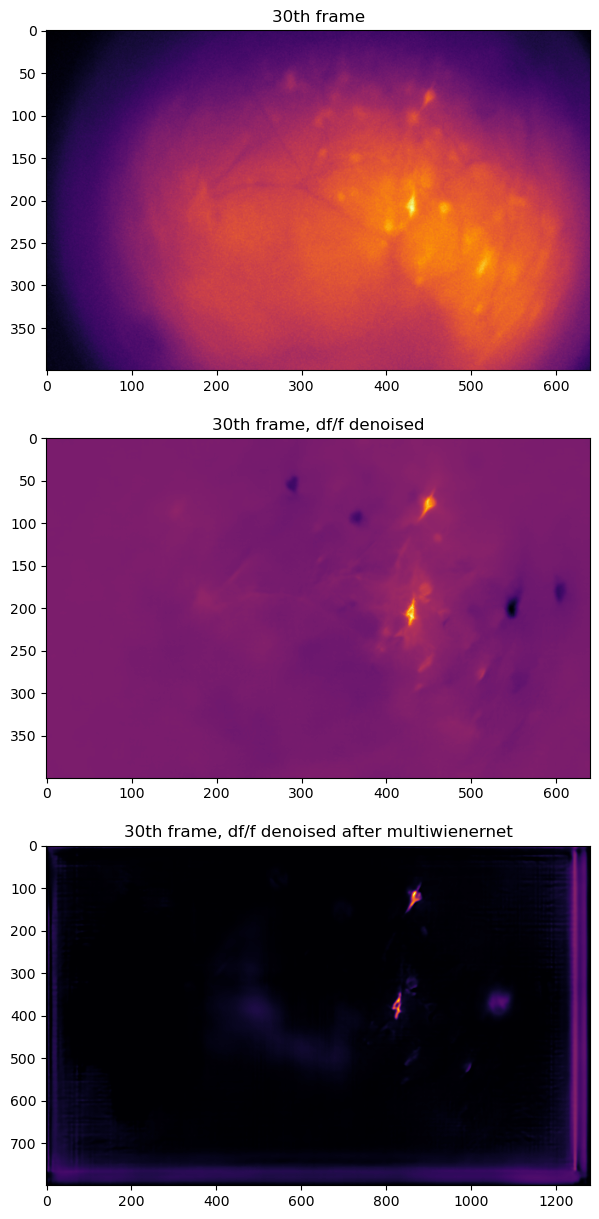

In [64]:
fig, axs = plt.subplots(3, 1, figsize=(15,15))
ind = 30

# background = np.mean(full_stack, axis=0)
# denoised_img = denoising.full_denoising(full_stack, ind, np.mean(full_stack, axis=0), h=8, num_images=5)
denoised_img = denoising.full_denoising(full_stack, ind, np.mean(full_stack, axis=0), h=8, num_images=5, denoising_method="NLM")
# denoised_img = denoising.full_denoising(full_stack, ind, background_lowpass, h=8, num_images=5)
# denoised_img = np.mean(denoising.get_similar(full_stack, ind, 5), axis=0)
# denoised_img = denoising.dff(np.mean(denoising.get_similar(full_stack, ind, 5), axis=0), np.mean(full_stack, axis=0))
# denoised_img = denoising.dff(full_stack[ind], np.mean(full_stack, axis=0))

# added median filtering
# denoised_img = scipy.signal.medfilt2d(denoised_img, kernel_size=5)

axs[0].imshow(full_stack[ind])
axs[0].set_title(str(ind) + "th frame")
axs[1].imshow(denoised_img)
axs[1].set_title(str(ind) + "th frame, df/f denoised")
axs[2].imshow((model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
axs[2].set_title(str(ind) + "th frame, df/f denoised after multiwienernet")

In [21]:
noise = denoising.dff(full_stack[ind], np.mean(full_stack, axis=0)) - denoising.full_denoising(full_stack, ind, np.mean(full_stack, axis=0), h=8, num_images=5)

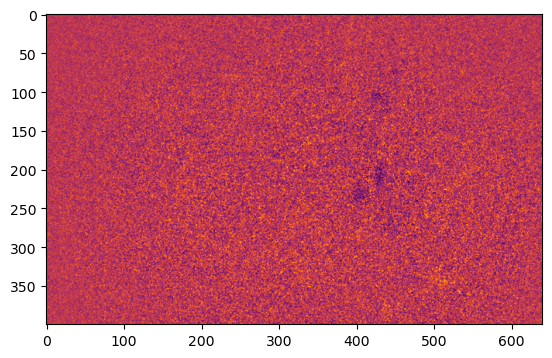

In [22]:
plt.imshow(noise)

In [23]:
np.var(noise)

126.37121932367678

In [24]:
np.max(denoising.dff(full_stack[ind], np.mean(full_stack, axis=0)))

244.6500000000001

In [25]:
np.sqrt(np.var(noise))*np.sqrt(5)

25.136747932427216

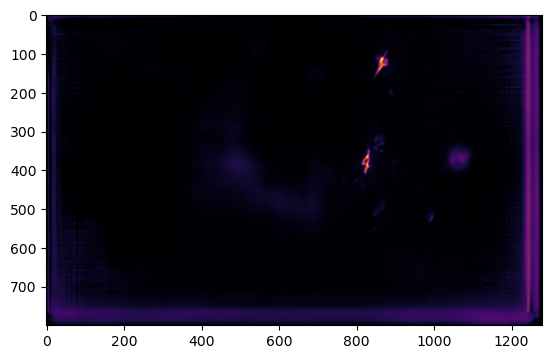

In [26]:
ind=30
denoised_img = denoising.full_denoising(full_stack, ind, np.mean(full_stack, axis=0), h=8, num_images=5)

# plt.figure(figsize=(800,1280), dpi=20)
plt.imshow((model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))

In [27]:
np.max(model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:])

175.25935

In [28]:
np.max(denoised_img)

254

In [29]:
a = np.arange(10)
a[5:6]

array([5])

In [30]:
movie_path = "/home/dshteinbok/denoising_experiments/2022-10-14-07-48-47_video.isxd"
raw_stack = isxd_reader.img_stack(movie_path)

On iteration 0, MSE is: 258.58061718749997
On iteration 1, MSE is: 268.67235546874997
On iteration 2, MSE is: 266.964015625
On iteration 3, MSE is: 269.8365703125


Text(0.5, 1.0, '50th image, no motion-correction')

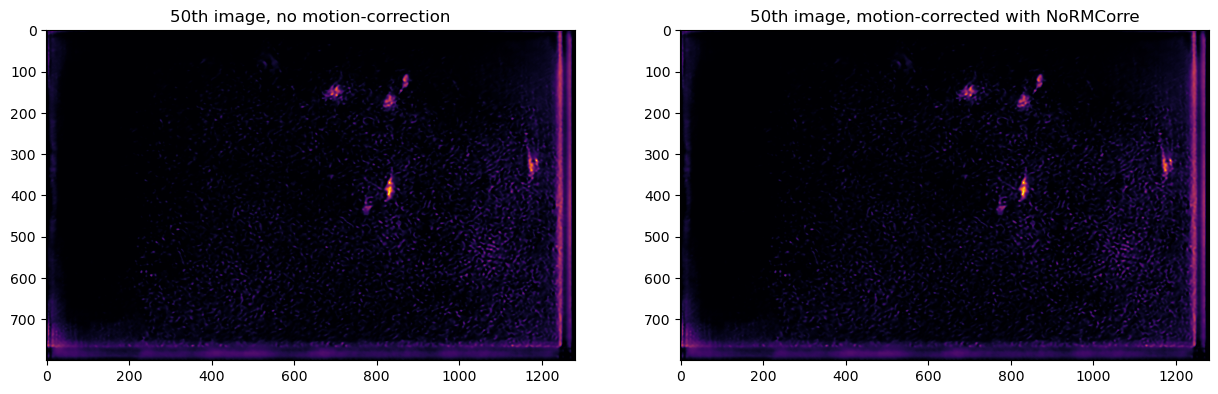

In [31]:
# compare the processed image from full_stack (which has been motion-corrected) with that from the raw
ind = 50
fig, axs = plt.subplots(1,2,figsize=(15,15))
denoised_normcorre = denoising.full_denoising(full_stack, ind, np.mean(full_stack, axis=0), h=4, num_images=5, verbose=True)
denoised_raw = denoising.full_denoising(raw_stack, ind, np.mean(raw_stack, axis=0), h=4, num_images=5)
axs[1].imshow(model(cv2.resize(denoised_normcorre, (1280, 800)).reshape((1,800,1280,1)))[0,:,:])
axs[1].set_title(str(ind) + "th image, motion-corrected with NoRMCorre")
axs[0].imshow(model(cv2.resize(denoised_raw, (1280, 800)).reshape((1,800,1280,1)))[0,:,:])
axs[0].set_title(str(ind) + "th image, no motion-correction")

In [32]:
# noise = denoising.full_denoising(full_stack, ind, np.mean(full_stack, axis=0), num_images=5)-denoising.full_denoising(full_stack, ind, np.mean(full_stack, axis=0), num_images=1)
noise = denoising.full_denoising(raw_stack, ind, np.mean(raw_stack, axis=0), num_images=5)-denoising.full_denoising(raw_stack, ind, np.mean(raw_stack, axis=0), num_images=1)

In [33]:
np.var(noise[150:350, 100:300])

13292.65122559

In [34]:
np.sqrt(1151)

33.926390907374746

In [35]:
noise.max()

255

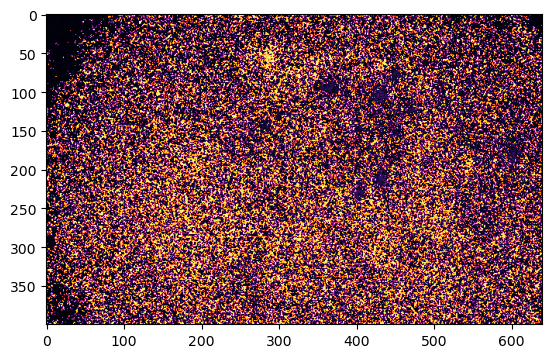

In [36]:
plt.imshow(noise)

In [37]:
denoised_img.max()

254

In [38]:
denoising.full_denoising(full_stack, ind+1, np.mean(full_stack, axis=0)).max()

255

In [39]:
full_stack.dtype

dtype('float64')

In [40]:
full_stack.max()

1683.0

## Testing Denoised, Background-In Image
Method: take raw image with background still in it, look at various methods of denoising to see effects of that

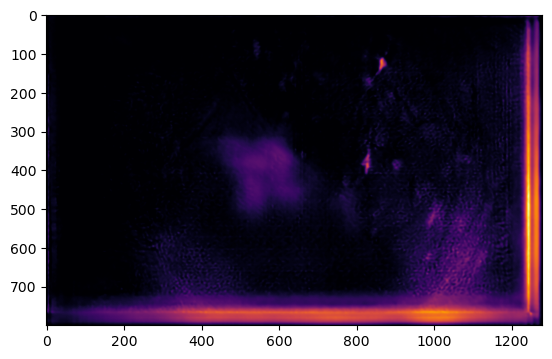

In [41]:
# "Control": just frame 30 of the movie, through NN directly
plt.imshow((model(cv2.resize(full_stack[30], (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))

Text(0.5, 1.0, 'Denoised, deconvolved')

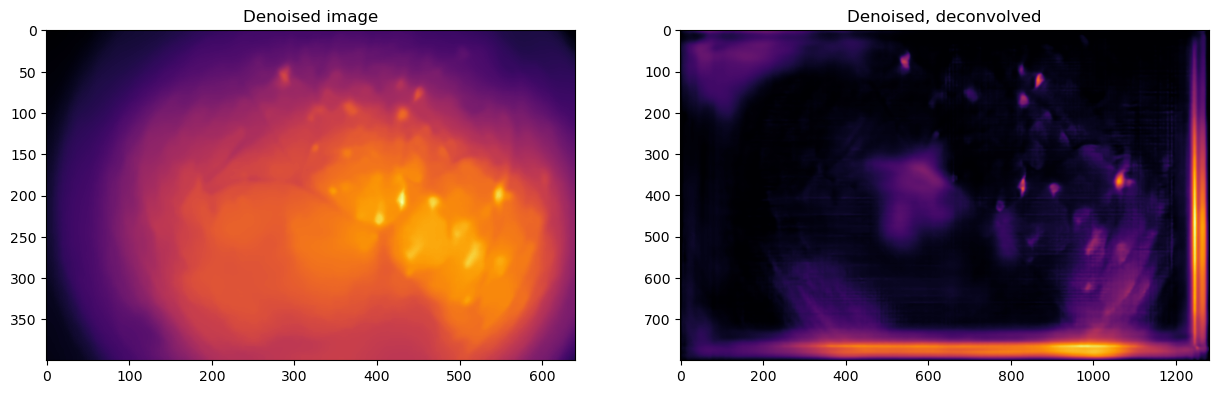

In [42]:
# Denoised image, through TLM and NLM
# to skip background removal, just give an ndarray of zeros as the background

ind=70
# f30_denoised_wbg =  denoising.full_denoising(full_stack, ind, np.zeros((400,640)), num_images=5, h=4)
f30_denoised_wbg =  denoising.full_denoising(full_stack, ind, np.zeros((400,640)), num_images=5, h=4)
# f30_denoised_wbg = np.mean(denoising.get_similar(full_stack, ind, 5), axis=0)
# f30_denoised_wbg = full_stack[ind]
fig, axs = plt.subplots(1,2,figsize=(15,15))
# axs[0].imshow(full_stack[30])
# axs[0].set_title("30th image")

axs[0].imshow(f30_denoised_wbg)
axs[0].set_title("Denoised image")
# axs[0].set_title("30th image")

axs[1].imshow((model(cv2.resize(f30_denoised_wbg, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
axs[1].set_title("Denoised, deconvolved")
# axs[1].set_title("30th image, deconvolved")

In [43]:
list(range(0))

[]

In [44]:
for i in range(0):
    print(i)

## Testing the preservation of lines
It was noticed that axons of cells were disappearing after having been processed by the neural network. These axons were thin lines. It may make sense that a line could have been produced by the convolution of a point with a long and thin PSF (as at the edge of the FOV of the optical system). Consequently, it would make sense that the multiwienernet may try to deconvolve the thin line that is the axon as a dotted line. In fact, this is exactly what was observed when the denoising was turned down (Updates.pptx, slide 200, slide 222).

Thus, I want to see whether this is reproducible in directly plugging in images of lines

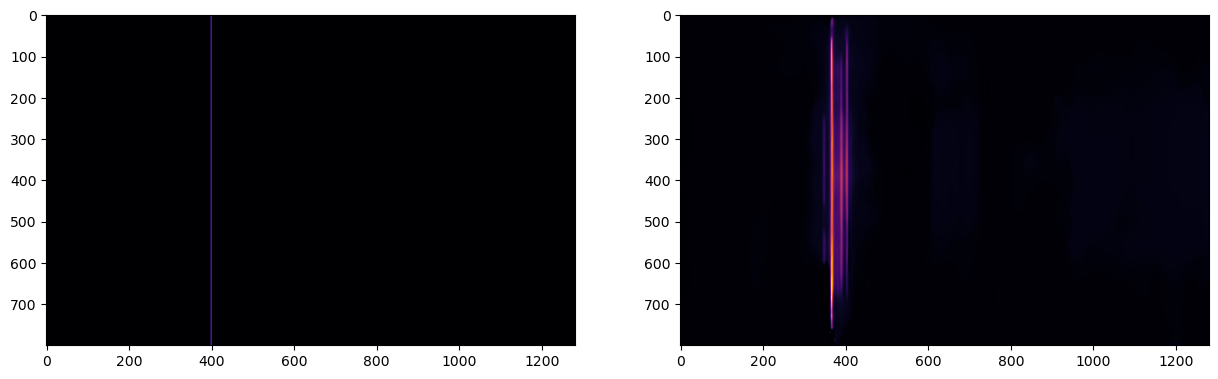

In [45]:
# test the ability of the neural network to just preserve a line through the input image

line_img = np.zeros((800,1280))

# this is the half-thickness less one; 
# this amount will be added to each side of the place we decide to draw the line
half_thickness_less_one = 0

#vertical line that goes all the way through the image from top to bottom in the center
img_center_vert = 400 
line_img[:, img_center_vert-half_thickness_less_one-1:img_center_vert+half_thickness_less_one] = 1

fig, axs = plt.subplots(1,2,figsize=(15,15))

axs[0].imshow(line_img)
axs[1].imshow((model(line_img.reshape((1,800,1280,1)))[0,:,:]))

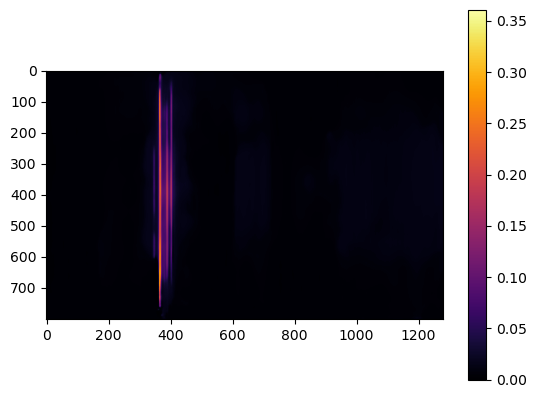

In [46]:
plt.imshow((model(line_img.reshape((1,800,1280,1)))[0,:,:]))
plt.colorbar()

Above, it seems that a single line gets turned into a bunch of fringes, although those fringes are significantly darker than the original image (original line has a peak value of 1, this one has a peak value of 0.35).

It should also be noted that the neural network generally decreases the peak brightness of the image. For example, the denoised 30th frame of the movie has a maximum value of 253, which is expected (brightness is scaled to single byte before NLM denoising), but after the neural network the deconvolved image has a peak brightness of 143.

**TODO:** Figure this out; what values does the NN take in the first place? When and how do we scale during the full denoising?

For now, continuing with the analysis of line behavior.
**TODO:**
* What are the effects of the angle of the line?
* What are the effects of the thickness of the line?
* What are the effects of noise?

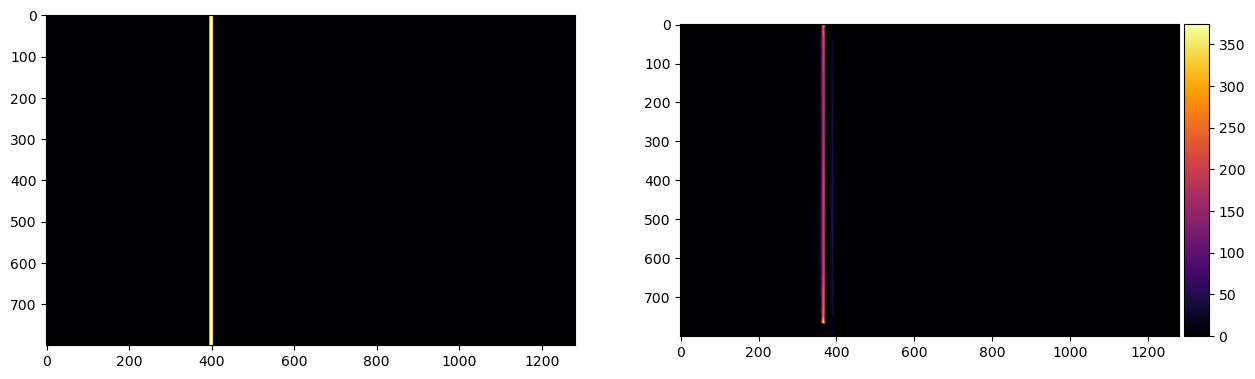

In [47]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Examining thickness
# copy-pasted from above, but with a different thickness value
line_img = np.zeros((800,1280))

# this is the half-thickness less one; 
# this amount will be added to each side of the place we decide to draw the line
# half_thickness_less_one = 5
# half_thickness_less_one = 2
# half_thickness_less_one = 3
half_thickness_less_one = 4
# half_thickness_less_one = 1

#vertical line that goes all the way through the image from top to bottom in the center
img_center_vert = 400 
line_img[:, img_center_vert-half_thickness_less_one-1:img_center_vert+half_thickness_less_one] = 255

fig, axs = plt.subplots(1,2,figsize=(15,15))

axs[0].imshow(line_img)
outimg = axs[1].imshow((model(line_img.reshape((1,800,1280,1)))[0,:,:]))

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(outimg, cax=cax, orientation='vertical')

In [48]:
np.max(model(line_img.reshape((1,800,1280,1)))[0,:,:])

374.04132

In [49]:
np.max(line_img)

255.0

Observed that the thicker the original line, the less fringing behavior we have from the NN.
Also observed an interesting phenomenn in the last ~20px in the y-direction, where the NN produces a gap and two dots. This seems to happen regardless of the thickness of the line.

Now, let's examine the same thing with shorter lines

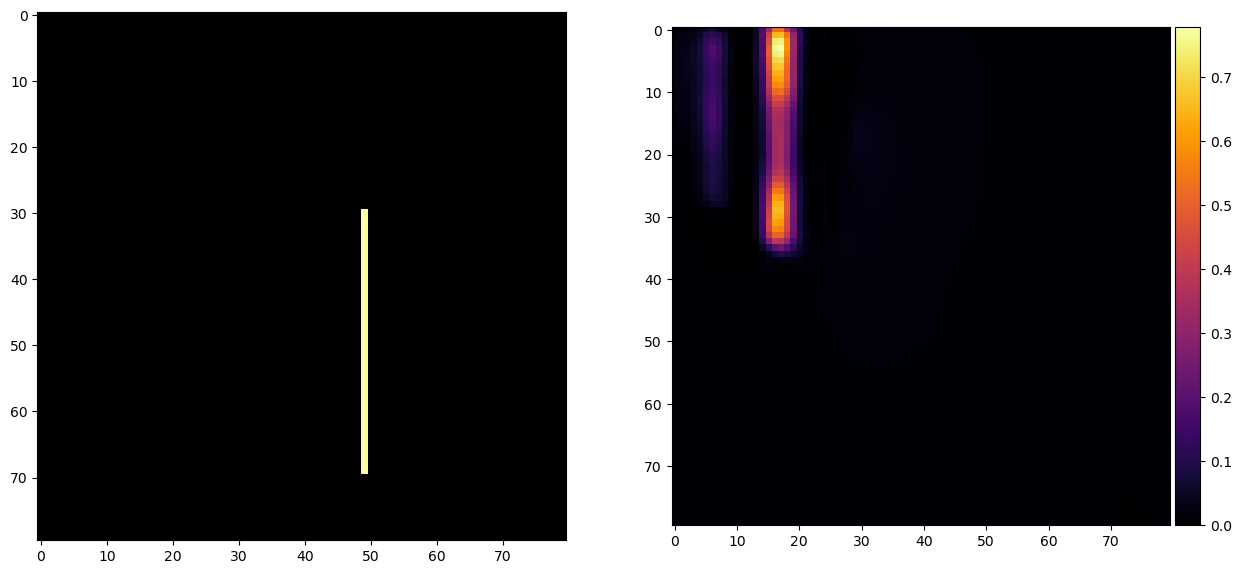

In [50]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Examining thickness
# copy-pasted from above, but with a different thickness value
line_img = np.zeros((800,1280))

# this is the half-thickness less one; 
# this amount will be added to each side of the place we decide to draw the line
# half_thickness_less_one = 5
# half_thickness_less_one = 2
# half_thickness_less_one = 3
# half_thickness_less_one = 4
# half_thickness_less_one = 1
half_thickness_less_one = 0
line_length = 40

#vertical line that goes all the way through the image from top to bottom in the center
img_center_vert = 400 
line_img[img_center_vert - line_length//2:img_center_vert + line_length//2,
         img_center_vert-half_thickness_less_one-1:img_center_vert+half_thickness_less_one] = 1

fig, axs = plt.subplots(1,2,figsize=(15,15))

axs[0].imshow(line_img[350:430, 350:430])
outimg = axs[1].imshow((model(line_img.reshape((1,800,1280,1)))[0,:,:])[350:430, 350:430])

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(outimg, cax=cax, orientation='vertical')

The shifting upward and to the left becomes apparent, but no serious dotting.

Now, to investigate diagonal lines:

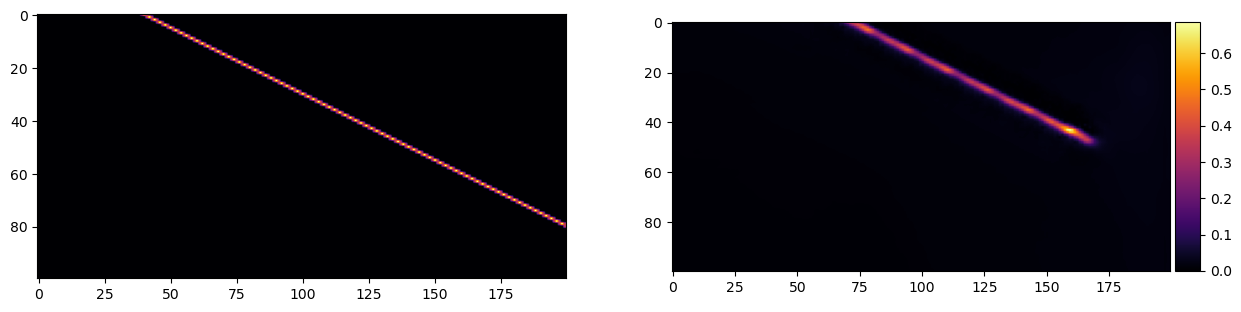

In [51]:
# to generate arbitrary diagonal lines, 
# we will need to generate three sets of points, then perform a linear interpolation over the entire image
# kind of tri-diagonal or something
slope = 0.5
x_length = 1280

# array of tuples containing coordinates of the non-zero values we care about
# we would simply shift these coordinates down by one and up by one to set the zero values
all_coords = []
all_vals = []
for i in range(x_length):
    all_coords.append((i, i*slope))
    all_vals.append(1)

# now we want to iterate through 1280 again for the lower zeros
# and then once more for the upper zeros
for i in range(x_length):
    all_coords.append((i, i*slope - 1))
    all_vals.append(0)
    
for i in range(x_length):
    all_coords.append((i, i*slope + 1))
    all_vals.append(0)

xq = np.arange(1280)
yq = np.arange(800)
[Xq, Yq] = np.meshgrid(xq, yq)

# we also need to surround the border with zeros, so the entire image is within the convex hull
# of our specified points
all_coords = all_coords + [(0, i) for i in range(800)] + [(1280, i) for i in range(800)] \
+ [(i, 0) for i in range(1280)] + [(i, 800) for i in range(1280)]

all_vals = all_vals + [0]*2*(800 + 1280)

line_img = scipy.interpolate.griddata(all_coords, all_vals, (Xq, Yq), method='linear')
line_img[np.isnan(line_img)] = 0
# plt.imshow(line_img)
# plt.colorbar()
fig, axs = plt.subplots(1,2,figsize=(15,15))

# axs[0].imshow(line_img)
axs[0].imshow(line_img[560:660, 1080:1280])
# outimg = axs[1].imshow((model(line_img.reshape((1,800,1280,1)))[0,:,:]))
outimg = axs[1].imshow((model(line_img.reshape((1,800,1280,1)))[0,:,:])[560:660, 1080:1280])

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(outimg, cax=cax, orientation='vertical')

### Addition of noise to line
Now, we want to see how the deconvolution of the line image will fare if AWGN is introduced to the vertical line.
This is pertinent because I expect it to exacerbate the dottiness of the line produced.

An important consideration is the standard deviation of the noise. I will start with the same level of AWGN I calculated for the actual observed $\Delta F/F$ images, but scaled to the (0,1) range. That is, $\sigma = 4.2/256 \approx 0.016$

**UPDATE:** I tried $\sigma=0.016$ and saw no result. I increased the standard deviation 10-fold from that point to get $\sigma=0.16$ which actually had an observable effect. This is what I ran below.

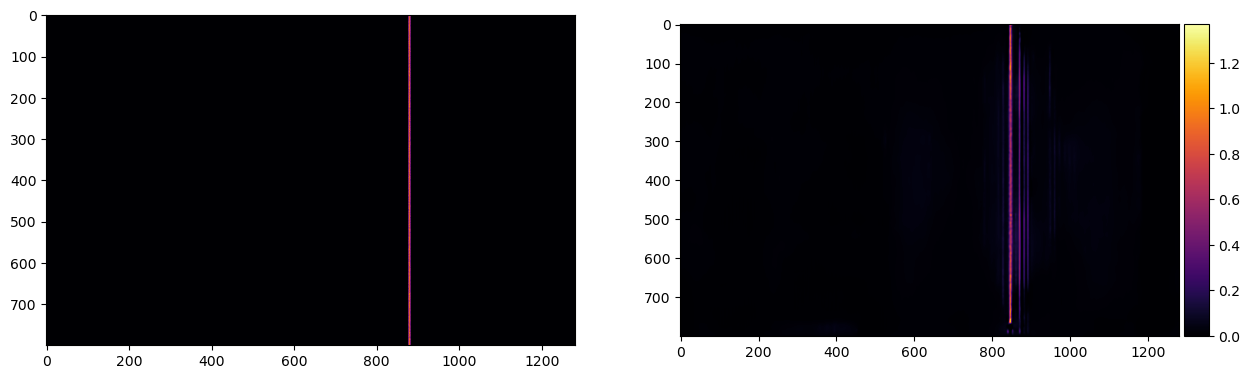

In [52]:
line_img = np.zeros((800,1280))

# this is the half-thickness less one; 
# this amount will be added to each side of the place we decide to draw the line
# half_thickness_less_one = 5
half_thickness_less_one = 2
# half_thickness_less_one = 3
# half_thickness_less_one = 4
# half_thickness_less_one = 1
# half_thickness_less_one = 0

#vertical line that goes all the way through the image from top to bottom in the center
img_center_vert = -400 
line_img[:, img_center_vert-half_thickness_less_one-1:img_center_vert+half_thickness_less_one] \
= np.random.normal(1, 0.16, size=(800, half_thickness_less_one*2 + 1))
# = np.random.normal(1, 0.16, size=(800, half_thickness_less_one*2 + 1))

fig, axs = plt.subplots(1,2,figsize=(15,15))

axs[0].imshow(line_img)
outimg = axs[1].imshow((model(line_img.reshape((1,800,1280,1)))[0,:,:]))

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(outimg, cax=cax, orientation='vertical')

Now, I just want to process every single frame of the movie, store all this in one big array and then save that big array as a `tif`.

In [53]:
# process the entire movie
out_movie_arr = np.empty((full_stack.shape[0], 800, 1280))

for ind in range(full_stack.shape[0]):
#     denoised_img = denoising.full_denoising(full_stack, ind, np.mean(full_stack, axis=0), h=8, num_images=5)
#     denoised_img = denoising.full_denoising(full_stack, ind, np.zeros((400,640)), h=4, num_images=1)
#     denoised_img = denoising.full_denoising(full_stack, ind, np.zeros((400,640)), h=4, num_images=5)
    denoised_img = full_stack[ind]
    out_movie_arr[ind] = (model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:])
    print("finished index: " + str(ind))

finished index: 0
finished index: 1
finished index: 2
finished index: 3
finished index: 4
finished index: 5
finished index: 6
finished index: 7
finished index: 8
finished index: 9
finished index: 10
finished index: 11
finished index: 12
finished index: 13
finished index: 14
finished index: 15
finished index: 16
finished index: 17
finished index: 18
finished index: 19
finished index: 20
finished index: 21
finished index: 22
finished index: 23
finished index: 24
finished index: 25
finished index: 26
finished index: 27
finished index: 28
finished index: 29
finished index: 30
finished index: 31
finished index: 32
finished index: 33
finished index: 34
finished index: 35
finished index: 36
finished index: 37
finished index: 38
finished index: 39
finished index: 40
finished index: 41
finished index: 42
finished index: 43
finished index: 44
finished index: 45
finished index: 46
finished index: 47
finished index: 48
finished index: 49
finished index: 50
finished index: 51
finished index: 52
fin

In [54]:
out_movie_arr.shape

(80, 800, 1280)

In [55]:
out_movie_arr.dtype

dtype('float64')

In [56]:
np.max(out_movie_arr)

520.8689575195312

In [57]:
# rescale the values of the pixels of the output movie to span 0 to 65535
out_movie_arr = out_movie_arr*65535/np.max(out_movie_arr)

In [58]:
out_movie_arr_uint = out_movie_arr.astype(np.uint16)

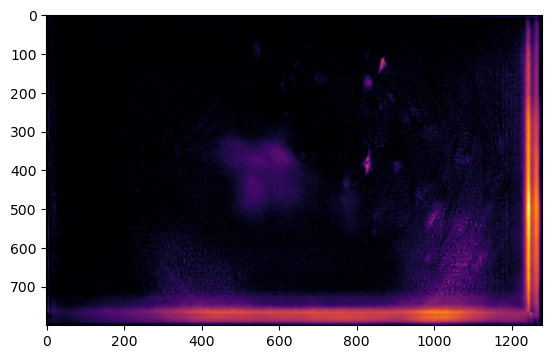

In [59]:
plt.imshow(out_movie_arr_uint[40])

In [60]:
import tifffile

# tifffile.imsave("post-nn_001.tif", out_movie_arr_uint)
# tifffile.imsave("post-nn_nlm_nobgr.tif", out_movie_arr_uint)
# tifffile.imsave("post-nn_nobgr_raw.tif", out_movie_arr_uint)

In [61]:
tifffile.imsave?